In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['font.size'] = "32"
from IPython.display import clear_output

# this code simulates the 3srw with trapping

In [2]:
def walkit(k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta1=0.5,theta2=0.5,retT=False,T='geom'):
    """
    kap is the trapping rate from rest
    k1 is the inverse mean resting time
    k2 is the inverse mean moving time
    v is the velocity
    dt is the sampling interval
    tmax is the maximum time to walk
    theta1 is the probability of starting at rest
    theta2 is the probability of starting in motion
    retT is True or False and tells the function whether to return the set of sampling times
    T is the set of sampling times. if 'geom',
    they are generated as geometrically spaced with 10 per order of magnitude
    if 'lin', they are generated with interval dt. 
    They can also be input as whatever else. 
    """
    # check if the initial conditions are appropriate
    if theta1+theta2!=1.0:
        raise Exception('Initial conditions do not sum to 1.0!')
    # selection the initial condition
    s = int(np.random.random() > theta1) + 1 # initial state
    
    # process the set of sampling times
    if T=='geom':
        nperorder = 10
        tmin = dt
        T = np.geomspace(tmin,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of recording times
    elif T=='dt':
        T = np.arange(0,tmax+dt,dt)
    else:
        raise Exception('Problem with the input T! not equal to geom or dt')
        
    # initialize the simulation
    X = np.empty_like(T) # set of recorded displacements
    t = 0.0 # initial time
    x = 0.0 # initial position
    ns = 0 # saving index
    ts = T[ns] # next saving time
    nr = 0 # random number index
    nrbatch = 5000 # number of random values to generate at once
    R = np.random.random(size=(nrbatch,2)) # generate the first set of random values
    # start the simulation
    while t<tmax-dt:
        t += dt # update the time 
        r1,r2 = R[nr] # get a pair of randoms
        nr+=1  #update the index into the array of random values
        if s==1: # if walker is in a rest state
            val1 = 1 - np.exp(-k1*dt) > r1 # probability that transition to motion occurs
            val2 = 1 - np.exp(-kap*dt) > r2  # probability that trapping occurs 
            if val1 and not val2: # provided walker does not trap and does transition to motion
                s = 2  # move it to the motion state
            elif val2: # otherwise if walker traps,
                s=0 # move it to the trapped state
                X[ns:]=x # make all future elements of X have position x
                break # stop the simulation
        elif s==2: # if walker is in a motion state
            x = x + v*dt # walker moves a distance v*dt
            if np.exp(-k2*dt)<r1: # if walker transitions to a rest state
                s = 1   # assign it to rest 
        ### save the state of the walk 
        if t>=ts: # if t surpassed the save time
            X[ns] = x # save the value of x 
            ns+=1 # increment the saving index
            ts=T[ns] # find the next time saving happens       
        ### generate more random values when necessary 
        if nr==nrbatch-1: # if you're at the end of the list of randoms
            nr = 0  # reset the index into that list 
            R = np.random.random(size=(nrbatch,2)) # and regenerate the list
    return X # once the simulation is completed, return the set of positions 

def ens(Nens = 100, k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-5,tmax=100,theta1=0.5,theta2=0.5,T='geom'):
    """ do an ensemble of Nens (number) simulations 
    rows (first index) of X are individual simulations
    use geometrically spaced sampling intervals if T='geom'.
    This is best for diffusion simulations. They will be viewed in
    log space anyway.
    otherwise if T='dt' sample at every timestep dt. 
    This gets very expensive but is nice for p(x,t) simulation"""
    T0 = np.copy(T)
    # generate the set of sampling times
    if T=='geom':
        nperorder = 10
        tmin = dt
        T = np.geomspace(tmin,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of recording times
    elif T=='dt':
        T = np.arange(0,tmax+dt,dt)      
    else:
        raise Exception('Problem with the input T! not equal to geom or dt')        
    # simulate the ensemble of walkers
    X = np.empty((Nens,T.size))
    for n in range(Nens):
        x = walkit(k1=k1,k2=k2,kap=kap,v=v,dt=dt,tmax=tmax,theta1=theta1,theta2=theta2,T=T0)
        X[n,:]=x
        clear_output(wait=True)
        print('sample {} of {}'.format(int(n+1),int(Nens)))
    # return the output
    return T,X

def cumulants(t,flag,k1,k2,kap,v,theta2):
    """ this provides the analytical cumulants from any initial conditions 
    flag =1 or 2 determines whether you want first or second cumulant"""
    # generate useful combinations and shorthands 
    kp = k1 + k2
    the2 = theta2
    exp=np.exp
    sqrt = np.sqrt
    a = (kap+kp)/2.0
    b = sqrt(a**2-kap*k2)
    # compute the polynomials/transcendentals from the table
    A1 = v/(2*b)*(the2+(the2*kap+k1)/(b-a))
    B1 = -v/(2*b)*(the2-(the2*kap+k1)/(a+b))
    C1 = -v/(2*b)*(1/(b-a)+1/(a+b))*(the2*kap+k1)
    def A2(t):
        out = (b*t-1)*(k1 + the2*(2*kap+k1+b-a))+the2*b
        out += (kap+k1)*(the2*kap+k1)/(b-a)**2*((b*t-1)*(b-a)-b) 
        out *= v**2/(2*b**3)
        return out
    def B2(t):
        out = (b*t+1)*(k1+the2*(2*kap+k1-a-b))+the2*b
        out += -(kap+k1)*(the2*kap+k1)/(a+b)**2*((b*t+1)*(a+b)+b)
        out *= v**2/(2*b**3)
        return out
    C2 = v**2/(2*b**3)*(kap+k1)*(the2*kap+k1)*((2*b-a)/(b-a)**2+(a+2*b)/(a+b)**2)
    # compute the mean or the variance, whichever is called for by 'flag'
    if flag==1: # compute the mean
        return A1*exp((b-a)*t)+B1*exp(-(a+b)*t)+C1
    elif flag==2: # compute the var
        out = (A2(t)-2*A1*C1-A1**2*exp((b-a)*t))*exp((b-a)*t)
        out += (B2(t)-2*B1*C1-B1**2*exp(-(a+b)*t))*exp(-(a+b)*t)
        out += C2 - C1**2 - 2*A1*B1*exp(-2*a*t)
        return out
    else:
        raise Exception('bad argument for flag! It should be 1 for the mean or 2 for the variance.')
        
def p(x,t,kap,k1,k2,v,theta2):
    """ plot the joint pdf over position and time.
    This is the analytical result from the paper 
    involving modified bessel functions and complementary
    marcum Q functions."""
    # compute other initial condition
    theta1 = 1.0-theta2 
    the1 = theta1 # shorthands 
    the2 = theta2
    # get useful functions
    from scipy.special import iv as I # modified bessel first kind
    from scipy.stats import ncx2 # non central chi-sq dist.
    from scipy.stats import norm # normal distribution to approximate dirac delta
    exp = np.exp # exponential 
    sqrt = np.sqrt #sqrt
    # make the arrays as high precision as possible to prevent
    # any overflow in the special functions
    t = np.asarray(t)  #so it can take a single value of t too 
    t = t.astype('float128') 
    x = x.astype('float64')
    # form useful combinations of k1,k2,kap,t,x,v
    kp = k1+k2
    tau = k1*(t-x/v)
    tau[tau<=0]=1e-9 # this keeps from dividing by zero
    xi = k2*x/v
    om = (kap+k1)/k1 
    H = np.heaviside(tau,1)
    # define the component special functions
    def delta(x):
        sig = 1e-2
        mu = 0 
        #return norm.pdf(x,mu,sig)
        return 0 # turn this off for now. doesn't matter
    def P1(x,y):
        # complementary marcum q function of order 1
        # P_1(x,y)= int_0^y dz e^{-z-x}I_0(2sqrt(xz))
        Q = ncx2.cdf
        return Q(y*2,df=2,nc=2*x)
    def P2(x,y):
        # complementary marcum q function of order 2
        # notice nc is 2x, df = 2mu, x = 2y to match
        # the notation in Temme 1996 eq. 11.63(a)
        # P_2(x,y)= int_0^y dz (z/x)^{1/2} e^{-z-x}I_0(2sqrt(xz))
        Q = ncx2.cdf
        return Q(y*2,df=4,nc=2*x)
    # now compute the distribution
    arg = 2*sqrt(tau*xi)
    out = the1*(1-1/om*(1-exp(-(kap+k1)*t)))*delta(x)
    out += 1/v*exp(-om*tau-xi)*(the1*(k1*I(0,arg)+k2*sqrt(tau/xi)*I(1,arg))+the2*(k1*delta(tau)+k2*I(0,arg)+k1*sqrt(xi/tau)*I(1,arg)))
    if kap!=0: # don't bother with the marcum q function terms if the trapping process is off. These will go to zero anyway, or just explode
        out += 1/v*exp(-kap*xi/(kap+k1))*kap*k2/(kap+k1)*(the1/om*P2(xi/om,om*tau)+the2*P1(xi/om,om*tau)) #pdf from paper
    return out #out*H is probably more correct, but this works fine.    

# now study the diffusion 

In [302]:
tmotion = 10.0
trest = 100.0
ttrap = 1000.0

k2 = 1/tmotion
k1 = 1/trest
kap = 1/ttrap
v = 0.5
theta1 = 0.6
theta2 = 0.4

T,X = ens(300,dt=1e-3,tmax=1e6,k1=k1,k2=k2,kap=kap,theta1=theta1,theta2=theta2,v=v)

sample 300 of 300


In [45]:
tmotion = 10.0
trest = 100.0
ttrap = 1000.0

k2 = 1/tmotion
k1 = 1/trest
kap = 1/ttrap
a = (k1+k2+kap)/2
b = np.sqrt(a**2-kap*k2)
print(k2,k1,kap,a,b)

0.1 0.01 0.001 0.0555 0.05459166603063145


In [46]:
1/kap

1000.0

In [182]:
kap

5e-05

In [183]:
k1,k2,kap,v = set1

In [186]:
k1>k2

True

In [188]:
1/k2<1/k1

False

(0.01, 1000000000.0)

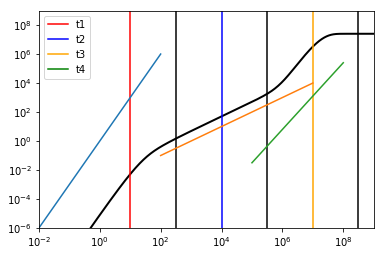

In [253]:
T = np.geomspace(1e-6,1e9,1000)
theta2 = 0
set1 = [1e-1,1e-4,1e-7,0.5]#[0.9,1e-1,1e-2,1]
k2,k1,kap,v = set1
def wrapper(T,seti):
    k2,k1,kap,v = seti    
    if (1/k2>1/k1) or (1/k1 > 1/kap) or (1/k2>1/kap):
        raise Exception(' wrong ordering of parameters!')

    return cumulants(T,2,k1,k2,kap,v,theta2)
def crossover(seti,color):
    sqrt = np.sqrt
    k2,k1,kap,v = seti

    t1 = 1/k2
    plt.axvline(t1,label='t1',color='red')
    
    t2 = 1/k1+1/k2 #1/k2
    plt.axvline(t2,label='t2',color='blue')
    t3 = 1/kap
    plt.axvline(t3,label='t3',color='orange')
    t4 = (k1+k2)/(k1*kap) # fraction of time spent in motion times 1/K
    plt.axvline(t4,label='t4',color='green')
    
    plt.axvline(sqrt(t1*t2),color='black')
    plt.axvline(sqrt(t3*t4),color='black')
    plt.axvline((t1*t2*t3*t4)**(1/4),color='black')
    plt.legend()
    #print(t4)
    #t5 = sqrt(t3*t4) # fraction of time spent in motion time 1/K
    #plt.axvline(t5,color=color)    
    #print(t3,t4)

plt.loglog(T,wrapper(T,set1),color='black',lw=2)#,marker='x',linestyle='None')
#plt.loglog(T,wrapper(T,set3),color='blue',lw=2)#,marker='x',linestyle='None')
crossover(set1,'black')
#crossover(set3,'blue')


t = np.geomspace(1e-2,1e2,100)
plt.loglog(t,t**3)
t = np.geomspace(1e2,1e7,100)
plt.loglog(t,t*1e-3)
t = np.geomspace(1e5,1e8,100)
plt.loglog(t,t**2.3*(1e-13))

plt.ylim(1e-6,1e9)
plt.xlim(1e-2,1e9)

In [199]:
1/(k1+k2)

0.9990009990009991

In [200]:
1/k2

1.0

In [ ]:
tm = 1
tr = 10
tt = 100000
k1 = 1/tr
k2 = 1/tm
kap = 1/tt
v=0.1


# k1/(k1+k2) is fraction of time spent in motion
# k2/(k1+k2) is fraction of time spent at rest

# crossover from 1st ballistic regime
time1 = 1/np.sqrt(k1*k2)
plt.axvline(time1,color='black')

# crossover zone from 2nd ballistic regime
tau1 = 1/kap
tau2 = 1/(k1*kap/(k1+k2))
time3 = np.sqrt(tau1*tau2)
plt.axvline(time3,color='black')
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\sigma_x^2(t)$',rotation=0,fontsize=12)

# crossover zone into 2nd ballistic regime
#plt.axvline(np.sqrt(1/kap/k2))
#plt.axvline(np.sqrt(1/kap*1/(k1*kap/(k1+k2))))

# mix the lower two times... 
time2 = (1/k1*tau2)**(1/2)
plt.axvline(time2,color='black')

fig = plt.gcf()
fig.set_figheight(7/1.6)
fig.set_figwidth(7)
fig.savefig('../grl/figures/diffusion.png', bbox_inches='tight',dpi=600)

In [ ]:
# code scrap to draw the three ranges onto a plot 
val = 1e-2
# local range
t0 = np.geomspace(1e-2,time1,100)
plt.loglog(t0,t0**3*val,linestyle='-.',color='black')
val = (t0**3*val).max()
# intermediate range
t1 = np.geomspace(time1,time2,100)
plt.loglog(t1,t1/t1.min()*val,linestyle='-.',color='black')
val = (t1/t1.min()*val).max()
# global range
t2 = np.geomspace(time2,time3,100)
plt.loglog(t2,t2**3/(t2**3).min()*val,linestyle='-.',color='black')
# geomorphic range

# scraps 
plt.loglog(T,X.var(0),'o',color='red',markersize=10,mfc='none')
plt.loglog(T,cumulants(T,2,k1,k2,kap,v,theta2=0.7),color='black',lw=3)
plt.ylim(1e-4,1e4)
plt.xlim(1e-2,1e7)

# simulate the joint pdf of x and t 

## simulate the pdfs for the paper 


In [14]:

# First simulate starting from rest with kappa nonzero
k2 = 1.0
k1 = 0.1
kap = 0.01
v = 2.0
theta1 =1.0 # start at rest 
theta2 = 0.0
T,X = ens(15000,dt=1e-2,tmax=200,k1=k1,k2=k2,kap=kap,theta1=theta1,theta2=theta2,v=v,T='dt') # do the ensemble simulation

### GENERATE THE HISTOGRAM 
# define bins over x axis
dl = 1.0
xbins = np.arange(0,np.nanmax(X)+dl,dl)
# define bins over t axis
dtau = 1.0
tbins = np.arange(0,T.max()+dtau,dtau)
Xs = X.flatten()
Ts = np.hstack((T,)*X.shape[0])
hist,_,_ = np.histogram2d(Xs,Ts,bins=[xbins,tbins])
hist = hist/hist.sum(0)/dl # this seems to normalize 
hist_t = hist
np.save('../simul/trap-pdf',{'tbins':tbins,'xbins':xbins,'pdf':hist_t})

# then simulate starting from rest with kappa zero
T,X = ens(15000,dt=1e-2,tmax=200,k1=k1,k2=k2,kap=0,theta1=theta1,theta2=theta2,v=v,T='dt') # do the ensemble simulation

### GENERATE THE HISTOGRAM 
# define bins over x axis
dl = 1.0
xbins = np.arange(0,np.nanmax(X)+dl,dl)
# define bins over t axis
dtau = 1.0
tbins = np.arange(0,T.max()+dtau,dtau)
Xs = X.flatten()
Ts = np.hstack((T,)*X.shape[0])
hist,_,_ = np.histogram2d(Xs,Ts,bins=[xbins,tbins])
hist = hist/hist.sum(0)/dl # this seems to normalize 
hist_nt = hist
del hist 
np.save('../simul/notrap-pdf',{'tbins':tbins,'xbins':xbins,'pdf':hist_nt})

sample 15000 of 15000


## make the two panel plot of the pdf with and without trapping

length 3.35; angle = 0.39
length 2.45; angle = 0.77
length 0.85; angle = 1.35
length 3.65; angle = 0.44
length 3.45; angle = 0.81
length 1.1; angle = 2.19


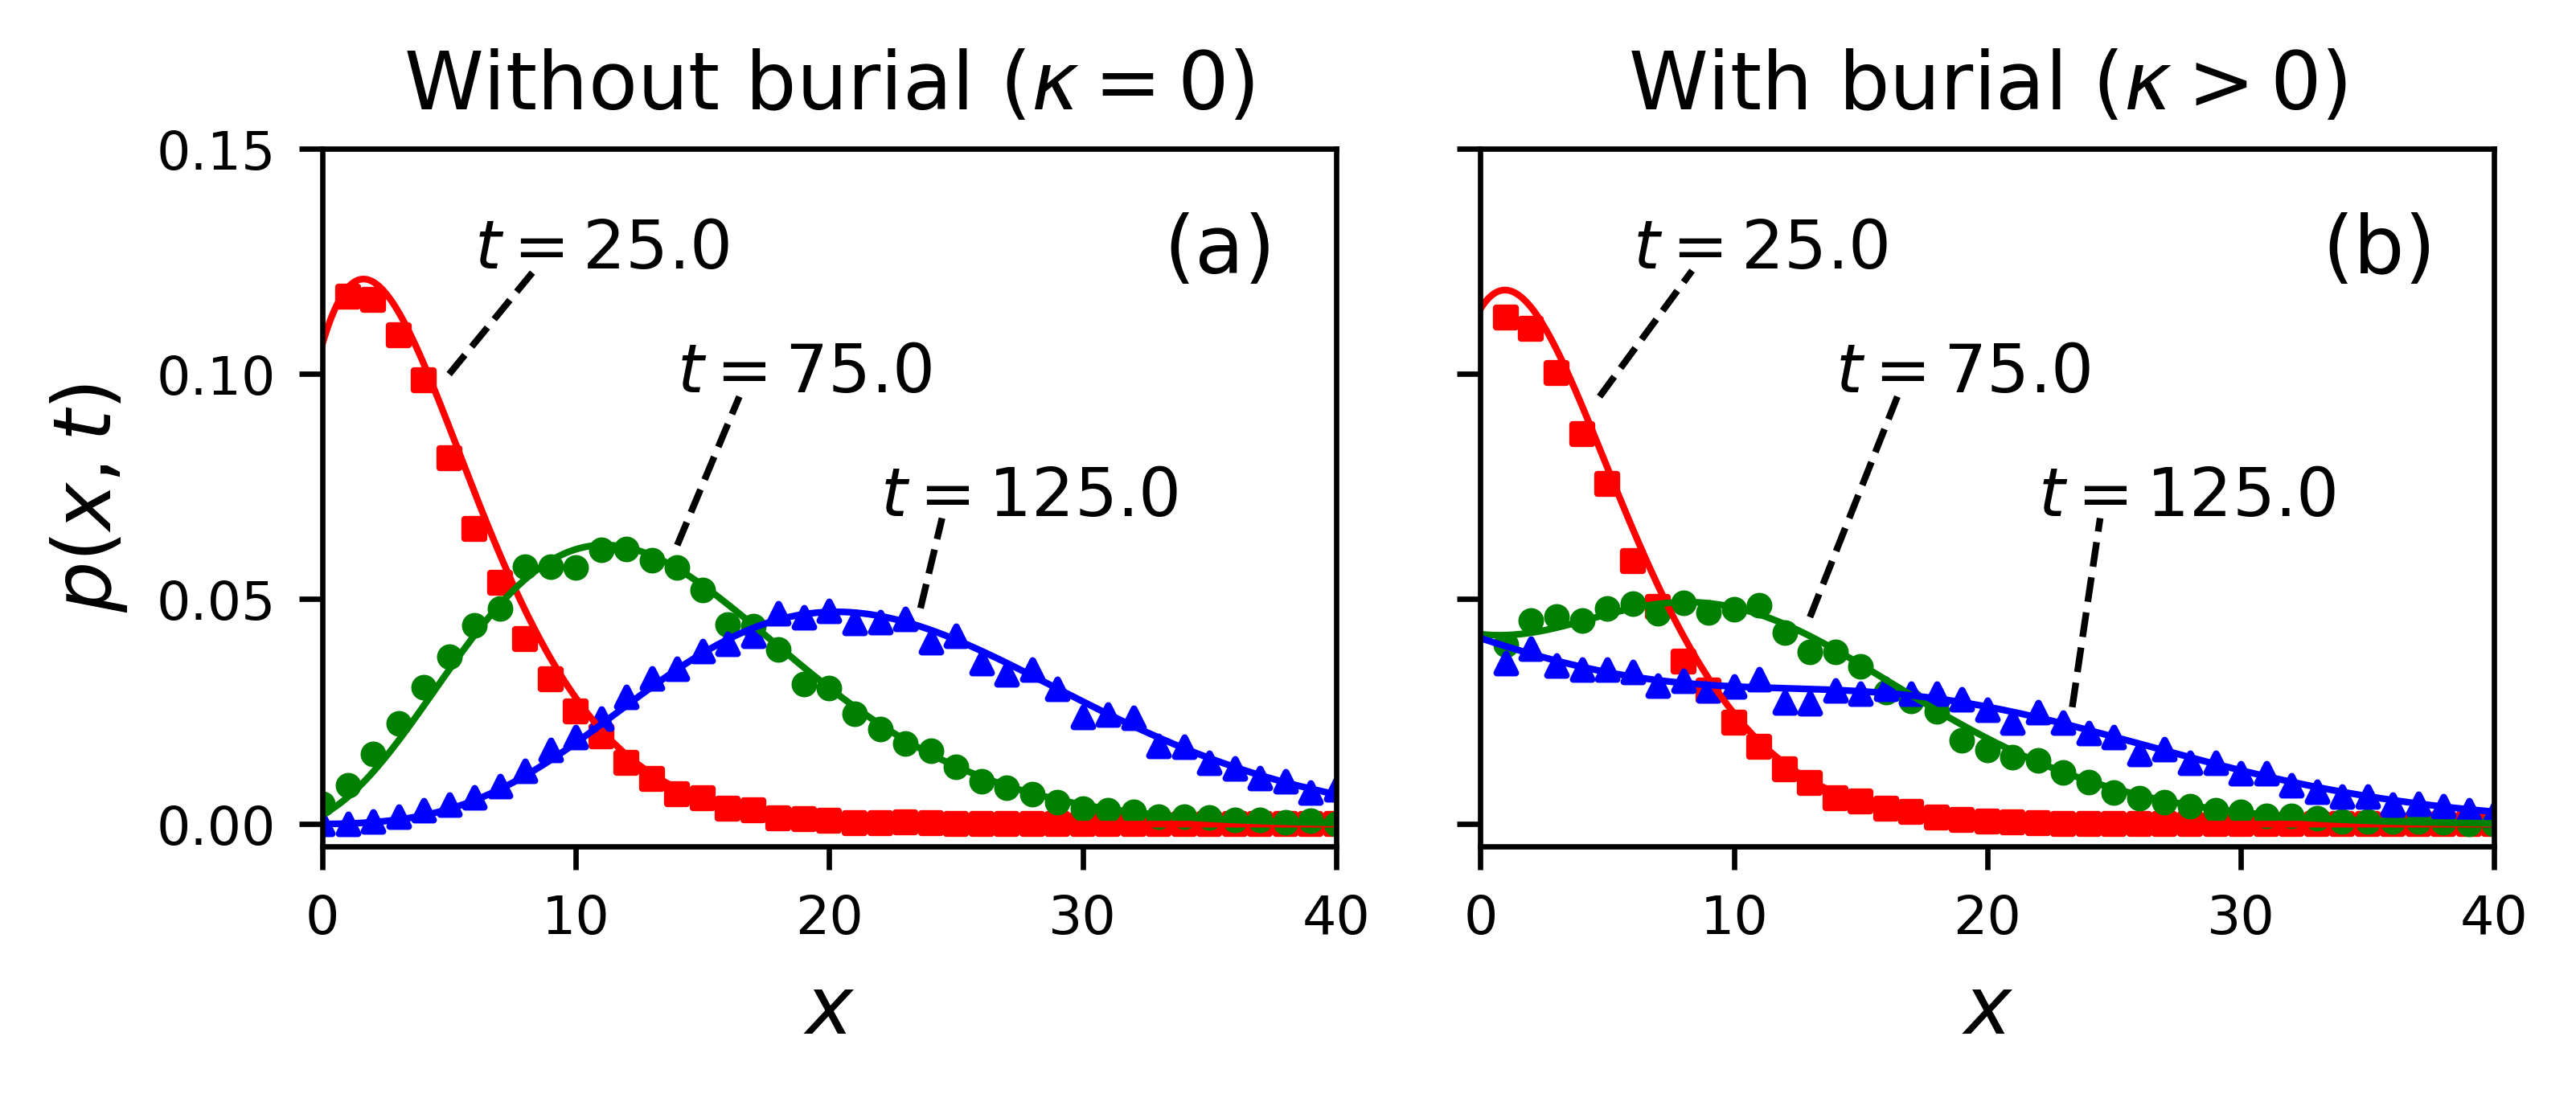

In [297]:
# now make the two panel plot without and with trapping
import matplotlib.pyplot as plt
# set the fonts 
smallsize = 8
medsize = 12
plt.rc('font', size=medsize)          # controls default text sizes
plt.rc('axes', titlesize=medsize)     # fontsize of the axes title
plt.rc('axes', labelsize=medsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=smallsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=smallsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=medsize)    # legend fontsize
plt.rc('figure', titlesize=medsize)  # fontsize of the figure title

# useful function to find the histograms you want to plot
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
x = xbins[:-1]
t1 = 25.0
i1 = find_nearest(tbins,t1)
t2 = 75.0
i2 = find_nearest(tbins,t2)
t3 = 125.0
i3 = find_nearest(tbins,t3)

# make the plot
w = 5.50107 # width of figure in inches 
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(w,3.9/1.6), dpi=600) # trial and error height

# first subplot
# simulation data
ax1.scatter(x, hist_nt[:,i1],color='red',marker='s',s=8)
ax1.scatter(x, hist_nt[:,i2],color='green',marker='o',s=8)
ax1.scatter(x, hist_nt[:,i3],color='blue',marker='^',s=8)
# set the ranges for the plot
ax1.set_xlim(0,40)
ax1.set_ylim(-0.005,0.15)
# titles and labels first subplot
ax1.set_xlabel(r'$x$',fontsize=12)
ax1.set_ylabel(r'$p(x,t)$',fontsize=12)
ax1.set_title(r'Without burial ($\kappa=0$)',fontsize=12)
ax1.text(0.83, 0.91, '(a)', transform=ax1.transAxes,fontsize=12, va='top')
# plot the analytical solutions
xp = np.linspace(1e-6,x.max(),1000)
colors = ['red','green','blue']
for ti,c in zip([t1,t2,t3],colors):
    ax1.plot(xp,p(xp,ti,0,k1,k2,v,theta2),color=c,lw=1,zorder=1)

# second subplot
# simulation data
ax2.scatter(x, hist_t[:,i1],color='red',marker='s',s=8)
ax2.scatter(x[1:], hist_t[1:,i2],color='green',marker='o',s=8)
ax2.scatter(x[1:], hist_t[1:,i3],color='blue',marker='^',s=8)
# set the ranges for the plot
ax2.set_xlim(0,40)
ax2.set_ylim(-0.005,0.15)
# titles and labels second subplot
ax2.set_xlabel(r'$x$',fontsize=12)
ax2.set_title(r'With burial ($\kappa>0$)',fontsize=12)
ax2.text(0.83, 0.91, '(b)', transform=ax2.transAxes,fontsize=12, va='top')
# plot the analytical solutions
for ti,c in zip([t1,t2,t3],colors):
    ax2.plot(xp,p(xp,ti,kap,k1,k2,v,theta2),color=c,lw=1,zorder=1)

# make the cascading time labels
lab1 = r'$t=25.0$'
lab2 = r'$t=75.0$'
lab3 = r'$t=125.0$'
x1 = 6
y1 = 0.135
x3 = 22
y3 = 0.08
x2 = (x1+x3)/2.0
y2 = (y1+y3)/2.0
ax1.text(x1,y1, lab1,fontsize=10, va='top')
ax2.text(x1,y1, lab1,fontsize=10, va='top')
ax1.text(x2,y2, lab2,fontsize=10, va='top')
ax2.text(x2,y2, lab2,fontsize=10, va='top') 
ax1.text(x3,y3, lab3,fontsize=10, va='top')
ax2.text(x3,y3, lab3,fontsize=10, va='top') 

# make the line segments to connect labels to curves on first subplot
def line(ax,x1,y1,x2,y2):
    x = [x1,x2]
    y = [y1,y2]
    l = round(np.sqrt((x2-x1)**2+(y2-y1)**2),2)
    ang = round(np.arctan((y2-y1)/(x2-x1))*180/np.pi,2)
    print('length {}; angle = {}'.format(l,ang))
    return ax.plot(x,y,color='black',linestyle='--',lw=1)
line(ax1,5,0.1,8.35,0.123)
line(ax1,14,0.062,16.45,0.095)
line(ax1,23.6,0.048,24.45,0.068)

line(ax2,4.7,0.095,8.35,0.123)
line(ax2,13.0,0.046,16.45,0.095)
line(ax2,23.35,0.026,24.45,0.068)

# overall figure layout + save the plot
fig.tight_layout()
fig.savefig('../grl/figures/pdf-plot.png', bbox_inches='tight')